#Import libraries

In [4]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#!pip install seaborn
import seaborn as sns
import nltk
import nltk.stem 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import string
import re
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
!pip install wordcloud
from wordcloud import WordCloud



[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Load data

data = pd.read_csv('https://otf.ca/sites/default/files/OTF-Grants_since2000.csv')

#Set a new index

data_index = pd.Series(range(27953)) 
data = data.set_index([data_index])

#Drop unnecessary columns

data = data.drop(columns=['Funding Org:Org subventionnaire', 'Country Served:Pays servis', 'Province Served:Province servis', 'Cross-catchment indicator:Indicateur interrégional', 'Co-Application:Co-demandeurs', 'Description (French/Français)', 'Grant Result:Résultat de subvention','Rescinded/Recovered:Révoqué/récupéré','Rescinded/Recovered Initiated By:Révoqué/récupéré intié par','Amount Rescinded/Recovered:Montant révoqué/récupéré', 'Last modified:Mise à jour'])
data.columns = ['fiscal_year','grant_program','geographical_area','identifier','org_name','submission_date', 'approval_date', 'amount_applied', 'amount_awarded', 'planned_duration', 'description', 'program_area', 'budget_fund', 'org_incorporation_num', 'org_charitable_reg_num', 'org_city', 'org_postcode', 'population_served', 'age_group']
description = pd.DataFrame(data, columns = ['description'])

#Descriptives - Grant Program Frequency Distribution

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


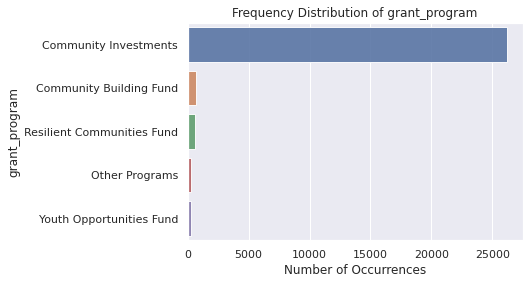

In [6]:
#Examining the data - Grant Program Frequency Distribution

grant_program_count = data['grant_program'].value_counts()
sns.set(style="darkgrid")
sns.barplot(grant_program_count.values, grant_program_count.index, alpha=0.9)
plt.title('Frequency Distribution of grant_program')
plt.ylabel('grant_program', fontsize=12)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.show()

#Data Cleaning

In [7]:
#Data Cleaning

recompute = False #to reduce re-run time

if recompute:
# Preprocessing text - Project description - using regx. Remove structured text and keep only free-form text

    a = description['description'].str.split('programs for Ontarians by ').str[1].dropna()
    b = description['description'].str.split('grant over \d+ years to ').str[1].dropna()
    c = description['description'].str.split('rebuild and recover from impacts of COVID-19 by ').str[1].dropna()
    d = description['description'].str.split('grant over \d+ months to ').str[1].dropna()
    e = description['description'].str.split('\$\d+( \w+|[\d,]+) over \d+ months to ').str[2].dropna()
    f = description['description'].str.split('\$\d+( \w+|[\d,]+) over one year to ').str[2].dropna()
    g = description['description'].str.split('\$\d+( \w+|[\d,]+) over two years to ').str[2].dropna()
    h = description['description'].str.split('\$\d+( \w+|[\d,]+) over three years to ').str[2].dropna()
    i = description['description'].str.split('\$\d+( \w+|[\d,]+) over six months to ').str[2].dropna()
    j = description['description'].str.split('This project aims to ').str[1].dropna()

    description_clean = pd.concat([a, b, c, d, e, f, g, h, i, j], axis=0,ignore_index=False)
    description_clean = description_clean.to_frame()

    add_indices = pd.Index(range(27952)).difference(description_clean.index)
    add_df = pd.DataFrame(index=add_indices, columns=description_clean.columns).fillna(description)
    description_clean = pd.concat([description_clean, add_df])

#Apply lemmatization to reduce redundancy
    lemmatizer = WordNetLemmatizer()
        # get_wordnet_pos from Selva Prabhakaran @ Machine Learning Plus
        # https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    def get_wordnet_pos(word):
            """Map POS tag to first character lemmatize() accepts"""
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)

    descriptions = []
    for i in description_clean['description']:
          descriptions.append(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(i.lower())]))

    descriptions=pd.DataFrame(descriptions, columns=['description'])

    def clean_text (df):
        description_C = list()
        lines = descriptions["description"].values.tolist()
        for text in lines:
            text = text.lower()
            text = re.sub(r"i'm", "i am", text)
            text = re.sub(r"he's", "he is", text)
            text = re.sub(r"she's", "she is", text)
            text = re.sub(r"that's", "that is", text)        
            text = re.sub(r"what's", "what is", text)
            text = re.sub(r"where's", "where is", text) 
            text = re.sub(r"\'ll", " will", text)  
            text = re.sub(r"\'ve", " have", text)  
            text = re.sub(r"\'re", " are", text)
            text = re.sub(r"\'d", " would", text)
            text = re.sub(r"\'ve", " have", text)
            text = re.sub(r"won't", "will not", text)
            text = re.sub(r"don't", "do not", text)
            text = re.sub(r"did't", "did not", text)
            text = re.sub(r"can't", "can not", text)
            text = re.sub(r"it's", "it is", text)
            text = re.sub(r"couldn't", "could not", text)
            text = re.sub(r"have't", "have not", text)
            text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
            tokens = word_tokenize(text)
            table = str.maketrans('', '', string.punctuation)
            stripped = [w.translate(table) for w in tokens]
            words = [word for word in stripped if word.isalpha()]
            stop_words = set(stopwords.words("english"))
            stop_words.discard("not")
            words = [w for w in words if not w in stop_words]
            words = ' '.join(words)
            description_C.append(words)
        return description_C

    description_C = clean_text(descriptions)
    descriptions["description"] = description_C
    pd.DataFrame(descriptions).to_csv('descriptions.csv', index=False)
else:
    descriptions = pd.read_csv('descriptions.csv')

#Word Cloud

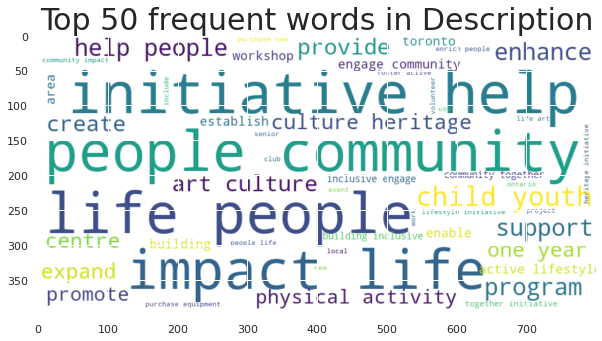

In [8]:
#Visualizing most frequently used words in project descriptions
stop_words = set(stopwords.words('english'))
wc = WordCloud(scale=2, background_color="white", max_words = 50, stopwords = stop_words)
wc.generate(' '.join(descriptions["description"].tolist()))
plt.figure(figsize=(10,7))
plt.title("Top 50 frequent words in Description",fontsize=30)
plt.xlabel("")
plt.ylabel("")
plt.imshow(wc,interpolation='bilinear')

#Feature Extractions

In [9]:
stop_noun = ['ontario', 'year', 'month','toronto','ottawa','people'] # Removing stopwords unique to this data
stop_words_full = text.ENGLISH_STOP_WORDS.union(stop_noun)
descriptions.columns = ['description']
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features = 100, stop_words = stop_words_full) # Extracting features
counts_sparse = vectorizer.fit_transform(descriptions['description'])
Extracted_Features = pd.DataFrame(counts_sparse.toarray(), index=descriptions.index, columns=vectorizer.get_feature_names())
#Extracted_Features = Extracted_Features.drop(Extracted_Features.columns[0:11], axis=1) 
Extracted_Features_index = pd.Series(range(27953)) # Establishing index
Extracted_Features = Extracted_Features.set_index([Extracted_Features_index])

#Merging Grant Program column with extracted features
Grant_program = pd.DataFrame (data, columns = ['grant_program'])
Grant_program =pd.concat([Grant_program, Extracted_Features], axis=1)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#Model Predictions

## Classifier: Naive Bayes

In [10]:
#Building a model
#Random Training Sample approx 80% of data
#Random_state=1 to maintain order
X1 = Grant_program.sample(22361, random_state=1) 
testing1 = Grant_program.drop(X1.index)

y1 = X1['grant_program']
y1.to_numpy(dtype=None, copy=False)

X1=X1.drop(['grant_program'], axis=1)
X1.to_numpy(dtype=None, copy=False)

t1_y = testing1['grant_program']
t1_y.to_numpy(dtype=None, copy=False)

t1_x=testing1.drop(['grant_program'], axis=1)
t1_x.to_numpy(dtype=None, copy=False)


#StratifiedKFold to preserve the percentage of samples for each class
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
X1_train, X1_validation, y1_train, y1_validation = train_test_split(X1, y1, test_size=0.20, shuffle= True, stratify= y1, random_state= 1)

# Baseline classifier using stratified
classifierNB = DummyClassifier(strategy='stratified') #stratified used due to uneven classes
classifierNB.fit(X1_train, y1_train)

# Baseline accuracy
pred_baselineNB = classifierNB.predict(X1_validation)
baseline_accuracyNB = accuracy_score(y1_validation, pred_baselineNB)
pd.Series(baseline_accuracyNB) 

#Training Model
model_NB = MultinomialNB()
model_NB.fit(X1_train, y1_train)
print('Model_NB is trained on {} data points'.format(X1_train.shape[0]))

#Validation Model
print('Model_NB is validated on {} data points'.format(X1_validation.shape[0]))
ValidationNB = model_NB.predict(X1_validation)
estNB_accuracy = accuracy_score(y1_validation, ValidationNB)

#Testing Model
PredictionNB = model_NB.predict(t1_x)
testNB_accuracy = accuracy_score(t1_y, PredictionNB)

print('Baseline accuracy(NB) score is', baseline_accuracyNB)
print('Estimated NB accuracy is', estNB_accuracy) #Validation accuracy
print('Test NB accuracy is', testNB_accuracy) 


Model_NB is trained on 17888 data points
Model_NB is validated on 4473 data points
Baseline accuracy(NB) score is 0.8826291079812206
Estimated NB accuracy is 0.9382964453386988
Test NB accuracy is 0.9404506437768241


## Classifier: Random Forest

###Random Forest with customized parameters

In [24]:
#Random Forest with customized paramenters
#Building a model
#Random Training Sample approx 80% of data
#Random_state=1 to maintain order
X = Grant_program.sample(22361, random_state=1) 
testing = Grant_program.drop(X.index)

y = X['grant_program']
y.to_numpy(dtype=None, copy=False)

X=X.drop(['grant_program'], axis=1)
X.to_numpy(dtype=None, copy=False)

t_y = testing['grant_program']
t_y.to_numpy(dtype=None, copy=False)

t_x=testing.drop(['grant_program'], axis=1)
t_x.to_numpy(dtype=None, copy=False)


#StratifiedKFold to preserve the percentage of samples for each class
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, shuffle= True, stratify= y, random_state= 1)

# Baseline classifier using stratified
classifier = DummyClassifier(strategy='stratified') #stratified used due to uneven classes
classifier.fit(X_train, y_train)

# Baseline accuracy
pred_baseline = classifier.predict(X_validation)
baseline_accuracy = accuracy_score(y_validation, pred_baseline)
pd.Series(baseline_accuracy) 


#Training Model
feature_scaler = StandardScaler() #Standardize features by removing the mean and scaling to unit variance
X_train_rf = feature_scaler.fit_transform(X_train) #Fit to data, then transform it.
X_validation_rf = feature_scaler.transform(X_validation)

param_grid = { 
        'n_estimators': [200], #various n_estimators were examined to determine the optimal number of trees in the forest.
    'max_features': ['auto'],
    'max_depth' : [15], #various tree depths were examined
    'criterion' :[ 'entropy'], #information gain was used to compare again the Gini index default
    'min_samples_leaf': [1] #A split point at any depth will be considered with at least 1 leaf
}

#GridSearchCV used to search the hyper-parameter space for the best cross validation score
rf_clfs = RandomForestClassifier(random_state=1)
rf_clf = GridSearchCV(estimator=rf_clfs, param_grid=param_grid, cv=k_fold,scoring='f1_micro') #micro used because data are not balanced
rf_clf.fit(X_train_rf,y_train)

print('Model is trained on {} data points'.format(X_train.shape[0]))

#Validation Model
print('Model is validated on {} data points'.format(X_validation.shape[0]))
pred = rf_clf.predict(X_validation_rf)

#Testing Model
print('Model is tested on {} data points'.format(t_x.shape[0]))
Prediction = rf_clf.predict(t_x)

print('Baseline accuracy(RF) score is', baseline_accuracy)
print('Estimated RF accuracy (validation model) is', f1_score(y_validation, pred, average='micro')*100) 
print('Test RF accuracy is', f1_score(t_y, Prediction, average='micro')*100)

Model is trained on 17888 data points
Model is validated on 4473 data points
Model is tested on 5592 data points
Baseline accuracy(RF) score is 0.8786049631120053
Estimated RF accuracy (validation model) is 95.059244355019
Test RF accuracy is 93.72317596566523


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
#Various indices were used to examine whether variations in number of trees, tree depth or splits would improve 
#the performance of the classifier. However, increasing the number of trees above 100 increased computational time and 
#decreasing the number of trees below 100 did not significantly improve prediction accuracy.
#Changing the criterion to measure the quality of a split from Gini to entropy also did not improve prediction accuracy.

###Random Forest with default parameters

In [12]:
#Random Forest with default parameters
#Building a model
#Random Training Sample approx 80% of data
#Random_state=1 to maintain order
X = Grant_program.sample(22361, random_state=1) 
testing = Grant_program.drop(X.index)

y = X['grant_program']
y.to_numpy(dtype=None, copy=False)

X=X.drop(['grant_program'], axis=1)
X.to_numpy(dtype=None, copy=False)

t_y = testing['grant_program']
t_y.to_numpy(dtype=None, copy=False)

t_x=testing.drop(['grant_program'], axis=1)
t_x.to_numpy(dtype=None, copy=False)


#StratifiedKFold to preserve the percentage of samples for each class
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, shuffle= True, stratify= y, random_state= 1)

# Baseline classifier using stratified
classifier = DummyClassifier(strategy='stratified')
classifier.fit(X_train, y_train)

# Baseline accuracy
pred_baseline = classifier.predict(X_validation)
baseline_accuracy = accuracy_score(y_validation, pred_baseline)
pd.Series(baseline_accuracy) 

#Training Model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
print('Model is trained on {} data points'.format(X_train.shape[0]))

#Validation Model
print('Model is validated on {} data points'.format(X_validation.shape[0]))
Validation = model.predict(X_validation)
est_accuracy = accuracy_score(y_validation, Validation)


#Testing Model
print('Model is tested on {} data points'.format(t_x.shape[0]))
Prediction = model.predict(t_x)
test_accuracy = accuracy_score(t_y, Prediction)

print('Baseline accuracy(RF) score is', baseline_accuracy)
print('Estimated RF accuracy (validation model) is', est_accuracy) #Validation accuracy
print('Test RF accuracy is', test_accuracy) 

#Random Forest outperformed MultinomialNB therefore the RF classifier was used in the final model. 
#Default RFparameters outperformed customized parameters and were retained for the final model

Model is trained on 17888 data points
Model is validated on 4473 data points
Model is tested on 5592 data points
Baseline accuracy(RF) score is 0.8774871450927789
Estimated RF accuracy (validation model) is 0.9510395707578806
Test RF accuracy is 0.9533261802575107


[[  69   47    0    4    0]
 [   8 5222    7    4    0]
 [   0   45    2    0    0]
 [   7   75    0   38    0]
 [   0   64    0    0    0]]
                            precision    recall  f1-score   support

   Community Building Fund       0.82      0.57      0.68       120
     Community Investments       0.96      1.00      0.98      5241
            Other Programs       0.22      0.04      0.07        47
Resilient Communities Fund       0.83      0.32      0.46       120
  Youth Opportunities Fund       0.00      0.00      0.00        64

                  accuracy                           0.95      5592
                 macro avg       0.57      0.39      0.44      5592
              weighted avg       0.93      0.95      0.94      5592



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 12.5, 'Predicted score')

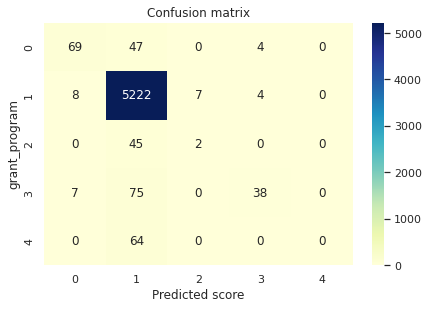

In [13]:

#Visualizing the Validation RF Model's Performance

cnf_matrixRF = metrics.confusion_matrix(t_y, Prediction)
print(cnf_matrixRF)
print(classification_report(t_y, Prediction))
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrixRF), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')    
plt.ylabel('grant_program')
plt.xlabel('Predicted score')


#K means cluster

##Range 2-10

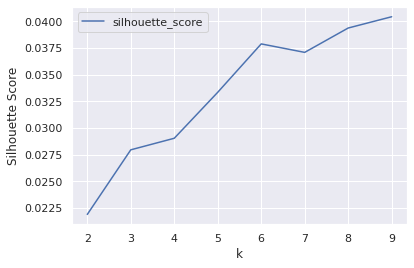

In [14]:
# Scale Extracted_Features from 0 to 1
Extracted_Features_scaled =  (Extracted_Features - Extracted_Features.min()) / (Extracted_Features.max() - Extracted_Features.min())

recompute = False #to reduce re-run time

if recompute:

# Plot the silhouette

  silhouette_list = []
  for k in range(2,10): #range chosen to match current 5 grant categories
      model = KMeans(n_clusters=k)
      model.fit(Extracted_Features_scaled)
      cluster_id = pd.Series(model.predict(Extracted_Features_scaled))
      
      # The two following lines are equivalent
      silhouette = silhouette_score(Extracted_Features_scaled, cluster_id)
      
      silhouette_list.append({'k':k, 'silhouette_score':silhouette_score(Extracted_Features_scaled, cluster_id), 'label':cluster_id})
      silhouette_list=pd.DataFrame(silhouette_list)
      silhouette_list.to_csv('silhouette_list.csv', index=False)

      ax = pd.DataFrame(silhouette_list).set_index('k').plot.line()
      ax.set_ylabel('Silhouette Score')

else:
  silhouette_list = pd.read_csv('silhouette_list.csv')
  ax = pd.DataFrame(silhouette_list).set_index('k').plot.line()
  ax.set_ylabel('Silhouette Score')


##Apply k

###9 Clusters

The silhouette score graph revealed clear breaks at k=3, k=4, k=6, k=8, and k=9. Top features in each cluster were examined and the features in cluster k=9 were most clearly differentiated, most interpretable, and were deemed to be most representative of the data. Therefore, cluster k=9 was retained as the optimal number of clusters for the data.

In [15]:
#Use K means to cluster extracted features
# Apply k
recompute = False

if recompute:
    k_model9 = KMeans(n_clusters=9)
    k_model9.fit(Extracted_Features_scaled)
    cluster_assignment9 = k_model9.predict(Extracted_Features_scaled)
    clusters9=Extracted_Features_scaled.groupby(cluster_assignment9).mean()
 
    cluster_assignment9=pd.DataFrame(cluster_assignment9)
    cluster_assignment9.to_csv('cluster_assignment9.csv', index=False)

    clusters_index9 = pd.Series(range(9))
    clusters9['clusters9']=clusters_index9

    # convert the dataframes into a long format
    clusters9.set_index(['clusters9'], inplace=True)
    clusters9.columns.names = ['Features9']
    weights = clusters9.stack().to_frame()
    weights.columns = ['weights']
    clusters9=weights

    #reset index
    clusters9 = clusters9.reset_index()

    #sort data by clusters and weights
    clusters9=clusters9.sort_values(by=['clusters9','weights'], ascending=[True,False])
    clusters9.to_csv('clusters9.csv', index=False)
    clusters9_top5 = clusters9.groupby(["clusters9"]).apply(lambda x: x.sort_values(["weights"], ascending = False)).reset_index(drop=True)
    clusters9_top5=clusters9_top5.groupby('clusters9').head(5)
    clusters9_top5.to_csv('clusters9_top5.csv', index=False)
    clusters9_top5


else:
    clusters9 = pd.read_csv('clusters9.csv')
    clusters9_top5 = pd.read_csv('clusters9_top5.csv')
    
clusters9_top5


,clusters9,Features9,weights
0,0,purchase,0.311610
1,0,equipment,0.245735
2,0,new,0.096091
3,0,community,0.064124
4,0,provide,0.059278
5,1,community,0.144463
6,1,facility,0.138648
7,1,accessible,0.107840
8,1,make,0.095666
9,1,renovate,0.085679


#Merge extracted features to data

In [16]:
 #merge extracted features to data

recompute = False

if recompute:
#Drop unecessary columns
  Merged_data = pd.concat([data, Extracted_Features], axis=1)
  Merged_data = Merged_data.drop(['amount_awarded', 'geographical_area',	'identifier','planned_duration',
              'org_name',	'submission_date',	'approval_date',	'amount_applied',	'description',	
              'program_area',	'budget_fund',	'org_incorporation_num',	'org_charitable_reg_num',
              'org_city',	'org_postcode',	'population_served',	'age_group'], axis=1)

  #Recode Grant Program and Fiscal Year string data
  # creating a dict file 
  grants = {'Community Building Fund': 1,'Community Investments': 2, 'Other Programs':3, 'Resilient Communities Fund':4, 'Youth Opportunities Fund':5 }
  year = {'2021-2022':2021, '2020-2021':2020, '2019-2020':2019, '2018-2019':2018, '2017-2018':2017,
        '2016-2017':2016, '2015-2016':2015, '2014-2015':2014, '2013-2014':2013, '2012-2013':2012,
        '2011-2012':2011, '2010-2011':2010, '2009-2010':2009, '2008-2009':2008, '2007-2008':2007,
        '2006-2007':2006, '2005-2006':2005, '2004-2005':2004, '2003-2004':2003, '2002-2003':2002,
        '2001-2002':2001, '2000-2001':2000, '1999-2000':1999}
    

  # traverse through dataframe and writing values where key matches  
  Merged_data.grant_program = [grants[item] for item in Merged_data.grant_program]
  Merged_data.fiscal_year = [year[item] for item in Merged_data.fiscal_year]

  Merged_data.to_csv('Merged_data.csv', index=False)
else:
  Merged_data = pd.read_csv('Merged_data.csv')

#Add cluster assignment column
  cluster_assignment9 = pd.read_csv('cluster_assignment9.csv')
  Merged_data['cluster_assignment9']=cluster_assignment9


# Examining Grant Program distribution over the last 20 years

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0, 1, 'Community Building Fund'),
 Text(0, 2, 'Community Investments'),
 Text(0, 3, 'Other Programs'),
 Text(0, 4, 'Resilient Communities Fund'),
 Text(0, 5, 'Youth Opportunities Fund')]

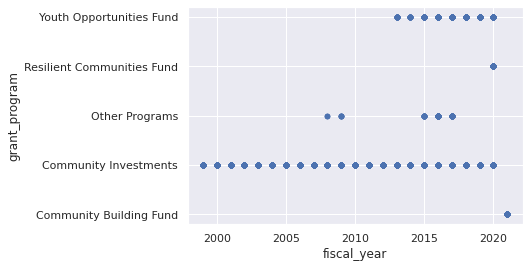

In [17]:
# Examining Grant Program distribution over the last 20 years

sns.set(style="darkgrid")
ax = Merged_data.plot.scatter('fiscal_year','grant_program')#, color=Merged_data['grant_program'].map(color_mapping))
plt.yticks(range(1, 6))
ax.set_yticklabels(('Community Building Fund','Community Investments', 'Other Programs', 'Resilient Communities Fund', 'Youth Opportunities Fund'))

[Text(0, 0, 'Equipment Upgrade Fund'),
 Text(0, 1, 'Accessibility Improvement Fund'),
 Text(0, 2, 'Community Impact Fund'),
 Text(0, 3, 'Organization Capacity-Building Fund'),
 Text(0, 4, 'Safety Improvement Fund'),
 Text(0, 5, 'Heritage & Culture Fund'),
 Text(0, 6, 'Volunteer Support & Training Fund'),
 Text(0, 7, 'Programme Development Fund'),
 Text(0, 8, 'Youth & Child Programme Fund')]

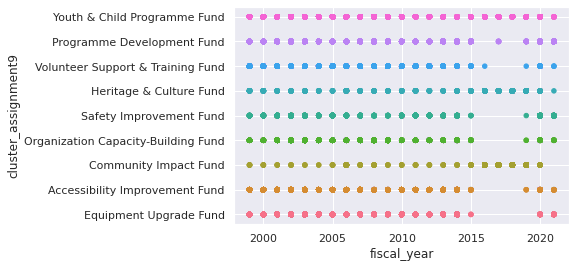

In [18]:
# Examining Cluster distribution over the last 20 years

colors = sns.color_palette('husl', n_colors=Merged_data['cluster_assignment9'].nunique()) 
colors_mapping = {x:colors[x] for x in Merged_data['cluster_assignment9'].unique()}

ax = Merged_data.plot.scatter('fiscal_year','cluster_assignment9', color=Merged_data['cluster_assignment9'].map(colors_mapping))
plt.yticks(range(0, 9))
ax.set_yticklabels(('Equipment Upgrade Fund', 'Accessibility Improvement Fund', 'Community Impact Fund', 'Organization Capacity-Building Fund', 
                    'Safety Improvement Fund', 'Heritage & Culture Fund', 'Volunteer Support & Training Fund', 'Programme Development Fund', 'Youth & Child Programme Fund'))

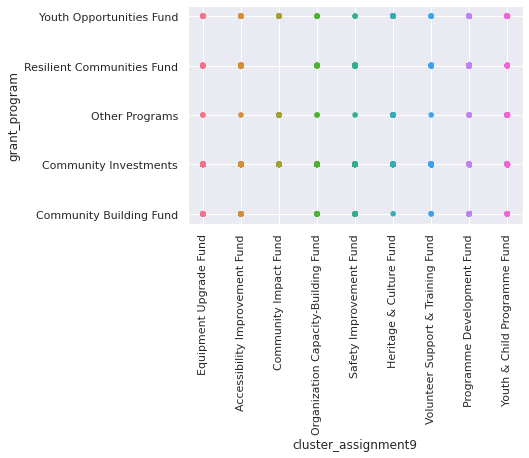

In [19]:
ax = Merged_data.plot.scatter('cluster_assignment9', 'grant_program', color=Merged_data['cluster_assignment9'].map(colors_mapping))
plt.yticks(range(1, 6))
ax.set_yticklabels(('Community Building Fund','Community Investments', 'Other Programs', 'Resilient Communities Fund', 'Youth Opportunities Fund'))
plt.xticks(range(0, 9))
ax.set_xticklabels(('Equipment Upgrade Fund', 'Accessibility Improvement Fund', 'Community Impact Fund', 'Organization Capacity-Building Fund', 
                    'Safety Improvement Fund', 'Heritage & Culture Fund', 'Volunteer Support & Training Fund', 'Programme Development Fund', 'Youth & Child Programme Fund'))
for item in ax.get_xticklabels():
    item.set_rotation(90)